In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import csv
import os
import logging
import sys
import traceback

In [2]:
# Traffic Sign Dataset Former
# used to pull images from GTSRB dataset
class TSDatasetFormer:
    def __init__(self) -> None:
        # get current directory
        self.curDir = os.getcwd()

        self.trainData = []
        self.trainLabels = []
        self.testData = []
        self.testLabels = []
        # GTSRB dataset includes 43 classes
        self.classes = 43
    
    def LoadTrainingData(self):
        for ii in range(self.classes):
            path = os.path.join(self.curDir, 'GTSRB\\Train', str(ii))
            trainingDataFileNames = os.listdir(path)

            for fileName in trainingDataFileNames:
                try:
                    image = Image.open(path + '\\' + fileName)
                    image = image.resize((30, 30))
                    image = np.array(image)

                    self.trainData.append(image)
                    self.trainLabels.append(ii)
                except:
                    excType, excValue, excTraceback = sys.exc_info()
                    lines = traceback.format_exception(excType, excValue, excTraceback)
                    print(''.join('!! ' + line for line in lines))
                    # logging.exception('.join('!! ' + line for line in lines))

        self.trainData = np.array(self.trainData)
        self.trainLabels = np.array(self.trainLabels)
    
    def LoadTestData(self):
        testFilesPath = os.path.join(self.curDir, 'GTSRB\\Test')
        testLabelsPath = os.path.join(self.curDir, 'GTSRB')
        
        testLabelsFile = file = open(testLabelsPath + '\\Test.csv')
        testcsvReader = csv.reader(testLabelsFile)

        # use manual iter and next function to skip the first element which is the format string ex:'ClassId'
        testcsvReaderIter = iter(testcsvReader)
        next(testcsvReaderIter)
        for row in testcsvReaderIter:
                # labels are stored in the 7th column of every row
                self.testLabels.append(row[6])

        # [:-1] to skip the last file which is 'GT-final_test.csv' (not an image)
        testDataFileNames = os.listdir(testFilesPath)[:-1]

        for fileName in testDataFileNames:
                try:
                    image = Image.open(testFilesPath + '\\' + fileName)
                    image = image.resize((30, 30))
                    image = np.array(image)

                    self.testData.append(image)
                except:
                    excType, excValue, excTraceback = sys.exc_info()
                    lines = traceback.format_exception(excType, excValue, excTraceback)
                    print(''.join('!! ' + line for line in lines))
                    # logging.exception('.join('!! ' + line for line in lines))
        
        self.testData = np.array(self.testData)
        self.testLabels = np.array(self.testLabels)

        # randomize train data together with labels
        trainRandomizedIndex = np.random.permutation(len(self.trainData))
        self.trainData, self.trainLabels = self.trainData[trainRandomizedIndex], self.trainLabels[trainRandomizedIndex]

    # returns training data in channel, x, y form
    def GetTrainData(self):
        cxy = np.swapaxes(self.trainData, 1, 3)
        cxy = np.swapaxes(cxy, 2, 3)
        return cxy
    
    # returns training labels in categorical form
    def GetTrainLabels(self):
        num_classes = 43
        return np.eye(num_classes, dtype='uint8')[self.trainLabels.astype(np.int32)]

    # returns test data in channel, x, y form
    def GetTestData(self):
        cxy = np.swapaxes(self.testData, 1, 3)
        cxy = np.swapaxes(cxy, 2, 3)
        return cxy
    
    # returns test labels in categorical form
    def GetTestLabels(self):
        num_classes = 43
        return np.eye(num_classes, dtype='uint8')[self.testLabels.astype(np.int32)]

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchview import draw_graph

In [4]:
datasetFormer = TSDatasetFormer()
datasetFormer.LoadTrainingData()
datasetFormer.LoadTestData()

# generate tensor datasets from training and test data
trainDataSet = TensorDataset(torch.from_numpy(datasetFormer.GetTrainData().astype(np.float32)), torch.from_numpy(datasetFormer.GetTrainLabels().astype(np.float32)))
testDataSet = TensorDataset(torch.from_numpy(datasetFormer.GetTestData().astype(np.float32)), torch.from_numpy(datasetFormer.GetTestLabels().astype(np.float32)))

# generate dataloader with tensor datasets
trainDataLoader = DataLoader(trainDataSet, batch_size=32, shuffle=True)
# test data shuffle is false for easier debugging
testDataLoader = DataLoader(testDataSet, batch_size=32, shuffle=False)

del datasetFormer

In [5]:
class TSModel(nn.Module):
    def __init__(self):
        super(TSModel, self).__init__()

        # localization network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=(7, 7)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=(5, 5)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.ReLU(True)
        )

        # regressor network with affine transform output
        self.regressor = nn.Sequential(
            nn.Linear(160, 32),
            nn.ReLU(True),
            nn.Linear(32, 6)
        )
        
        # initialize weights as zero and biases as identity for the last linear layer of regressor
        # this will make sure that the initial tranformation when training results in the same input image
        # (removing this can lead to weird transformations that the network finds is more efficient which may not be in line with how humans identify)
        for name, param in self.regressor.named_parameters():
            if(name == '2.weight'):
                param.data.zero_()
            if(name == '2.bias'):
                #identity matrix for affine
                param.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        # identification network
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(5, 5))
        self.maxPool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop1 = nn.Dropout(0.3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.maxPool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop2 = nn.Dropout(0.3)
        self.flat1 = nn.Flatten()
        self.lin1 = nn.Linear(576, 256)
        self.drop3 = nn.Dropout(0.5)
        self.lin2 = nn.Linear(256, 43)
    
    def forward(self, x):
        # input image is fed into localization network
        xs = self.localization(x)
        # results in (batch size, 160)
        xs = xs.view(-1, 160)
        # feed the reshaped input to regressor for affine transform mat
        theta = self.regressor(xs)
        # reshape affine transform mat for use in affine_grid function
        theta = theta.view(-1, 2, 3)

        # generate a sampling grid with affine transform mat
        grid = functional.affine_grid(theta, x.size(), align_corners=True)
        # sample the grid from the image
        x = functional.grid_sample(x, grid, align_corners=True)

        # identification network
        x = functional.relu(self.conv1(x))
        x = functional.relu(self.conv2(x))
        x = self.maxPool1(x)
        x = self.drop1(x)
        x = functional.relu(self.conv3(x))
        x = functional.relu(self.conv4(x))
        x = self.maxPool2(x)
        x = self.drop2(x)
        x = self.flat1(x)
        x = functional.relu(self.lin1(x))
        # removed softmax for crossentropy
        #x = functional.softmax(self.lin2(x), dim=1)
        x = self.lin2(x)
        return x

In [6]:
# get device for torch (cpu unless nvidia gpu or amd gpu with rocm)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# assign model to device
model = TSModel().to(device)

In [7]:
# graph the model for visualization
model_graph = draw_graph(model, input_size=(32, 3, 30, 30), expand_nested=True)
model_graph.visual_graph

In [7]:
# model trainer class to define custom training and test functions
class TSModelTrainer():
    def __init__(self, TSModel):
        self.model = TSModel

    def Train(self, device, trainDataLoader, epochs=20):
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        self.model.train()
        criterion  = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            for batchIdx, (data, target) in enumerate(trainDataLoader):
                data, target = data.to(device), target.to(device)

                self.optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                self.optimizer.step()
                if batchIdx % 500 == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batchIdx * len(data), len(trainDataLoader.dataset),
                        100. * batchIdx / len(trainDataLoader), loss.item()))
        print('End of Training\n')
    
    def Test(self, device, testDataLoader):
            with torch.no_grad():
                self.model.eval()
                testLoss = 0
                correct = 0
                criterion  = nn.CrossEntropyLoss()
                for data, target in testDataLoader:
                    data, target = data.to(device), target.to(device)
                    output = self.model(data)

                    # summing up the batch loss
                    testLoss += criterion(output, target).item()
                    # using the output to predict class (geting the index of the maximum probability)
                    pred = output.max(1, keepdim=True)[1]
                    targetCategorical = torch.argmax(target, dim=1)
                    correct += pred.eq(targetCategorical.view_as(pred)).sum().item()

                testLoss /= len(testDataLoader.dataset)
                print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
                    .format(testLoss, correct, len(testDataLoader.dataset),
                            100. * correct / len(testDataLoader.dataset)))
    

In [ ]:
modelTrainer = TSModelTrainer(model)
modelTrainer.Train(device, trainDataLoader, epochs=10)

In [19]:
# testing the model accuracy
modelTrainer.Test(device, testDataLoader)


Test set: Average loss: 0.0086, Accuracy: 12105/12630 (96%)



In [8]:
# loading the model (use with your own file path)
#model = torch.load('(your model path)')

In [9]:
labels = {  0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
           10:'No passing veh over 3.5 tons',
           11:'Right-of-way at intersection',
           12:'Priority road',
           13:'Yield',
           14:'Stop',
           15:'No vehicles',
           16:'Veh > 3.5 tons prohibited',
           17:'No entry',
           18:'General caution',
           19:'Dangerous curve left',
           20:'Dangerous curve right',
           21:'Double curve',
           22:'Bumpy road',
           23:'Slippery road',       
           24:'Road narrows on the right',
           25:'Road work',
           26:'Traffic signals',
           27:'Pedestrians',
           28:'Children crossing',
           29:'Bicycles crossing',
           30:'Beware of ice/snow',
           31:'Wild animals crossing',
           32:'End speed + passing limits',
           33:'Turn right ahead',
           34:'Turn left ahead',
           35:'Ahead only',
           36:'Go straight or right',
           37:'Go straight or left',
           38:'Keep right',
           39:'Keep left',
           40:'Roundabout mandatory',
           41:'End of no passing',
           42:'End no passing veh > 3.5 tons'}

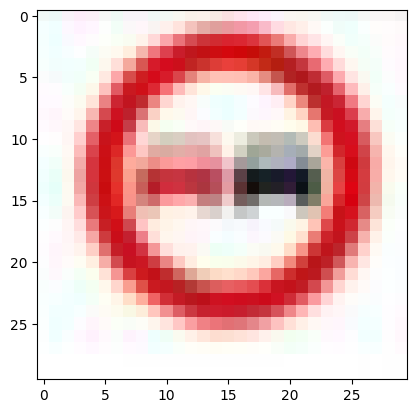

In [46]:
# you can use your own example image
#testImage = Image.open('(your image path)')
#testImage = testImage.resize((30, 30))
#testImage = np.array(testImage)
#plt.imshow(testImage)

In [47]:
# uncomment and test after setting the example image
"""testImage = testImage[:,:,:-1]
testImagecxy = np.swapaxes(testImage, 0, 2)
testImagecxy = np.swapaxes(testImagecxy, 1, 2)
testImagecxy = testImagecxy.astype(np.float32)
testImageicxy = np.expand_dims(testImagecxy, axis=0)
testImageTensor = torch.from_numpy(testImageicxy)

with torch.no_grad():
    output = model(testImageTensor)
    pred = output.max(1, keepdim=True)[1]
    prednp = pred.numpy()
    print(labels[prednp[0][0]])"""

No passing


In [73]:
batchSize = testDataLoader.batch_size
transformedTestImages = []
for data, target in testDataLoader:
    data, target = data.to(device), target.to(device)
    # manually set the affine transform data for first test batch pulled from debug
    grid = functional.affine_grid(torch.tensor([[[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]], [[ 0.7743, -0.0061, 0.0208], [ 0.0562, 0.7507, 0.1179]]], dtype=torch.float), data.size(), align_corners=True)
    transformedData = functional.grid_sample(data, grid, align_corners=True)
    transformedData = transformedData.numpy()
    for data in transformedData:
        xyc = np.swapaxes(data, 0, 2)
        xyc = np.swapaxes(xyc, 0, 1)
        xyc = xyc.astype(np.int32).tolist()
        transformedTestImages.append(xyc)
    break
transformedTestImages = np.array(transformedTestImages)

<Figure size 3000x3000 with 0 Axes>

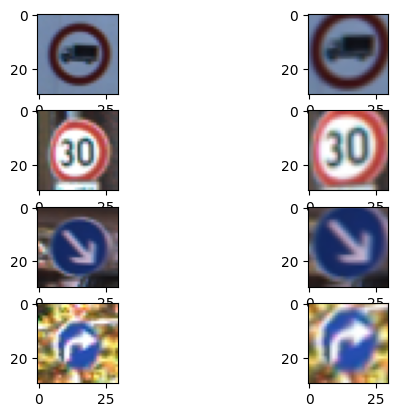

In [74]:
plt.figure(figsize=(30,30))
f, axarr = plt.subplots(4,2)
for testData, target in testDataLoader:
    testImages = []
    for data in testData:
        xyc = data.numpy()
        xyc = np.swapaxes(xyc, 0, 2)
        xyc = np.swapaxes(xyc, 0, 1)
        xyc = xyc.astype(np.int32).tolist()
        testImages.append(xyc)
    break

sampleSize = 4
for i in range(sampleSize):
    axarr[i, 0].imshow(testImages[i])
    axarr[i, 1].imshow(transformedTestImages[i])

In [14]:
# save the model (use with your own file path)
#torch.save(model, "(your file path)")